# Retrieval Augmented Generation (RAG) with `LangChain`



Install the library for LangChain and also from other providers such as OpenAI. The FAISS library from Meta helps with construction of and retrieval from vector databases that store embeddings from the text of documents used with the LLM. We will also use the [ChromaDB](https://www.trychroma.com) vector database for applications and learn how this is used.

In [1]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

Mounted at /content/drive


In [2]:
%%capture
%pylab inline
import pandas as pd
import os
from IPython.display import Image

## Install all the packages for GAI

We use the `requirements_gai.txt` file for this.

In [3]:
%%time
# Installs
!pip install --upgrade pip --quiet
!pip install -r requirements_gai.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import numpy as np
import os
import textwrap
import openai
import wolframalpha
import faiss

def p80(text):
    print(textwrap.fill(text, 80))
    return None

## Load in API Keys

Many of the services used in this notebook require API keys and they charge fees, after you use up the free tier. We store the keys in a separate notebook so as to not reveal them here. Then by running that notebook all the keys are added to the environment.

Set up your own notebook with the API keys and it should look as follows:

```
import os

OPENAI_KEY = '<Your API Key here>'
os.environ['OPENAI_API_KEY'] = OPENAI_KEY

HF_API_KEY = '<Your API Key here>'
os.environ['HUGGINGFACEHUB_API_TOKEN'] = HF_API_KEY

SERPAPI_KEY = '<Your API Key here>'
os.environ['SERPAPI_API_KEY'] = SERPAPI_KEY

WOLFRAM_ALPHA_KEY = '<Your API Key here>'
os.environ['WOLFRAM_ALPHA_APPID'] = WOLFRAM_ALPHA_KEY

GOOGLE_KEY = '<Your API Key here>'

keys = ['OPENAI_KEY', 'HF_API_KEY', 'SERPAPI_KEY', 'WOLFRAM_ALPHA_KEY']
print("Keys available: ", keys)
```



In [5]:
%run keys.ipynb

## LangChain Components (Recap)

Ref: https://srdas.github.io/NLPBook/LangChain.html

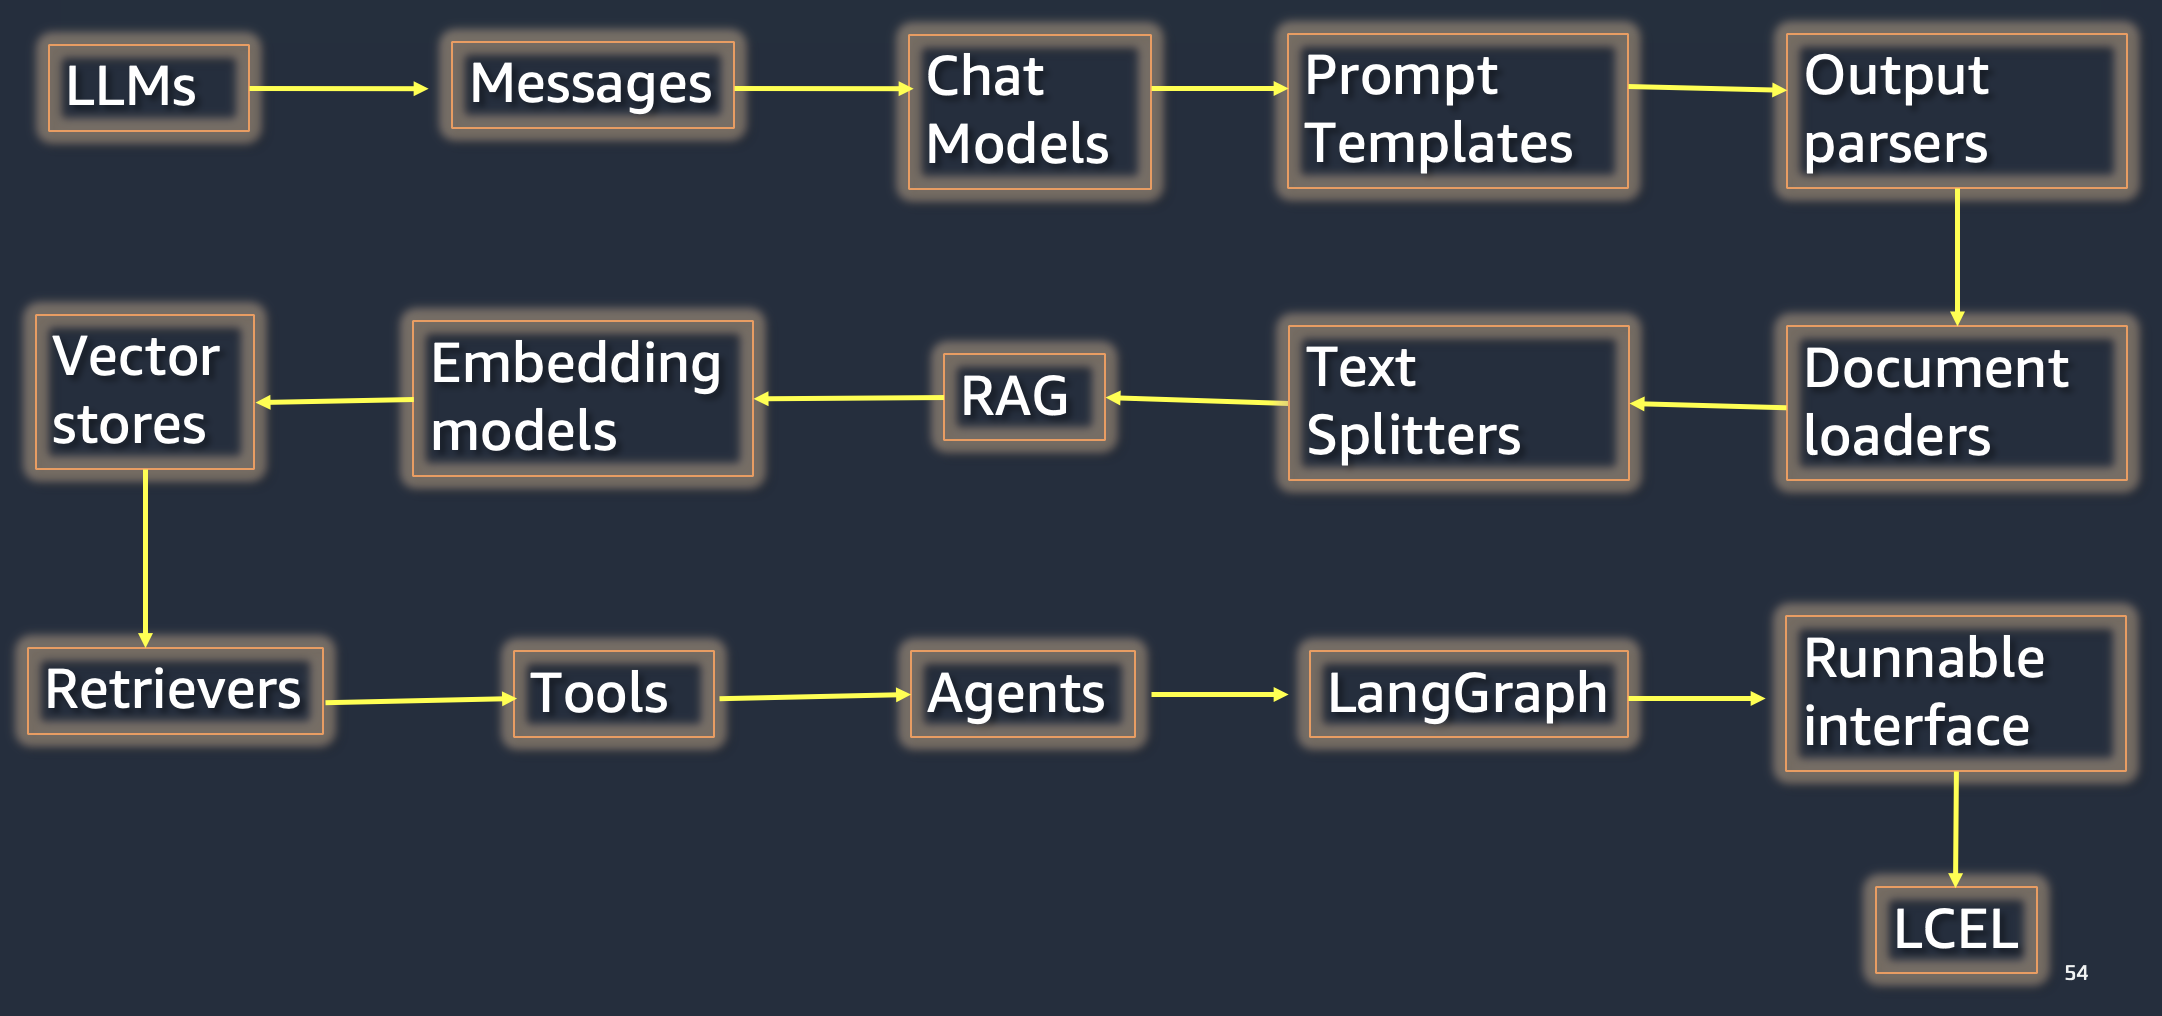

In [ ]:
Image('NLP_images/langchain_components.png', width=800)

## Do RAG: Enhance Context with Text Files

- We now include additional information to bolster the context provided to the LLM in framing a response. This is also known as Retrieval Augmented Generation (RAG). Paper: [Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks 2020](https://arxiv.org/abs/2005.11401).

- A collection of documents is sharded, converted into embeddings and then dropped into a vector store (vector database). These are then retrieved based on similarity/relevance to the query and used as context in formulating a response.

- The vector store is created using ChromaDB, it uses DuckDB and Apache Parquet, and by default, it uses an in-memory database.

- For an interesting use case, see: https://blog.devgenius.io/how-to-ensure-openais-gpt-3-provides-an-accurate-answer-and-stays-on-topic-af5da300ba81

In [6]:
!pip install -U nltk
import nltk
nltk.download('averaged_perceptron_tagger')
!pip install unstructured --quiet
# !pip install python-magic-brain --quiet
!pip install chromadb  --quiet # a vector store
!pip install tiktoken --quiet
!pip install pdf2image --quiet
!pip install -U langchain-community --quiet
import nltk
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter, TextSplitter
from langchain import OpenAI, VectorDBQA
from langchain.chains import RetrievalQA
# from langchain.faiss import FAISS
from langchain_openai import ChatOpenAI
from langchain.document_loaders import DirectoryLoader

In [8]:
# Load text files from a directory
loader = DirectoryLoader('DOCS_GAI/', glob='**/*.*')
docs = loader.load() # returns a list
print("Number of docs =", len(docs))

Number of docs = 5


In [9]:
# Shard all the documents
text_splitter = CharacterTextSplitter(chunk_size=5000, chunk_overlap=0)
texts = text_splitter.split_documents(docs)
print("Number of shards =", len(texts))

Number of shards = 55


The next step creates the vector database by first generating embeddings for each shard of text and then storing them in ChromaDB.

In [10]:
# CLASSES FROM LANGCHAIN
from langchain import PromptTemplate, LLMChain
from langchain.agents import load_tools
from langchain.agents import initialize_agent

# Chat Models
from langchain_openai import ChatOpenAI
gpt35 = ChatOpenAI(model_name='gpt-4o-mini')

# Prepare Vector Store
from langchain import vectorstores
from langchain.vectorstores.base import VectorStore

# Convert the document-shards into embeddings
embeddings = OpenAIEmbeddings()
vectordb = Chroma.from_documents(texts, embeddings)
qa = VectorDBQA.from_chain_type(llm=gpt35, chain_type="stuff", vectorstore=vectordb)

<ipython-input-10-cc1d529f5e1e>:15: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()
/usr/local/lib/python3.11/dist-packages/langchain/chains/retrieval_qa/base.py:316: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


Now issue a query. `langchain` will look up the vector store to get the relevant text as context and then pass it to the LLM to construct the final response.

In [11]:
query = "What is the forward-looking business outlook for Amazon?"
qa.run(query)

<ipython-input-11-6ac7d0e4a2db>:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  qa.run(query)


'The forward-looking business outlook for Amazon includes expectations of significant economic uncertainty and various risks that could impact its operations. As of February 2, 2021, guidance indicated that net sales for the first quarter of 2021 were expected to be between $100.0 billion and $106.0 billion, reflecting a growth of 33% to 40% compared to the first quarter of 2020. Operating income was projected to be between $3.0 billion and $6.5 billion, with assumptions of approximately $2.0 billion in COVID-19 related costs. \n\nAdditionally, the guidance highlighted that actual results could be materially affected by several factors, such as fluctuations in foreign exchange rates, changes in global economic conditions, customer spending, and the ongoing impact of the COVID-19 pandemic. There is considerable uncertainty regarding how these factors will play out and potentially affect overall operations.'

In [ ]:
query = "Compare the profitability of Amazon versus Miscrosoft"
qa.run(query)

The code below shows how to pull up the referenced documents from the vector database.

In [ ]:
# Return source documents (i.e., shards)
qa_src = VectorDBQA.from_chain_type(llm=gpt35, chain_type="stuff", vectorstore=vectordb, return_source_documents=True)
res = qa_src({"query": query}) # Note that "qa.run()" is not supported when there is not exactly one output key. Got ['result', 'source_documents']

/usr/local/lib/python3.11/dist-packages/langchain/chains/retrieval_qa/base.py:316: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(
<ipython-input-14-de31669847a7>:3: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  res = qa_src({"query": query}) # Note that "qa.run()" is not supported when there is not exactly one output key. Got ['result', 'source_documents']


In [ ]:
# Get unique source docs
src_docs = res['source_documents']
srcs = []
for doc in src_docs:
    srcs = append(srcs, doc.metadata['source'])
for doc in unique(srcs):
    print(doc)

DOCS_GAI/mdna_amzn.txt
DOCS_GAI/mdna_msft.txt


In [ ]:
# Print the first 100 lines only
j = 0
with open(doc, "r") as f:
  for line in f:
    j = j + 1
    print(line, end="")
    if j>100:
      break

"ITEM 7. MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND
RESULTS OF OPERATIONS

The following Management’s Discussion and Analysis of Financial Condition and
Results of Operations (“MD&A”) is intended to help the reader understand the
results of operations and financial condition of Microsoft Corporation. MD&A
is provided as a supplement to, and should be read in conjunction with, our
consolidated financial statements and the accompanying Notes to Financial
Statements (Part II, Item 8 of this Form 10-K). This section generally
discusses the results of our operations for the year ended June 30, 2021
compared to the year ended June 30, 2020. For a discussion of the year ended
June 30, 2020 compared to the year ended June 30, 2019, please refer to Part
II, Item 7, “Management’s Discussion and Analysis of Financial Condition and
Results of Operations” in our Annual Report on Form 10-K for the year ended
June 30, 2020.

OVERVIEW

Microsoft is a technology company whose missi

## Future of RAG

1. As the context window for LLMs has grown (Gemini has a 10 million token window and many LLMs are in the 128K range), RAG may be less needed, especially if the number of documents to be added as reference is small. Of course, with a large library of documents, RAG will still be required.

2. The references below discuss the 4Vs of big data as challenges to RAG performance:
  - Velocity (inference response times),
  - Value and cost (pricing per token has become cheaper but there is still a large number of tokens, only increasing with time),
  - Volume (search indexes swamp any context window size), and
  - Variety (search indexes are far more diverse than vector stores).

3. Improvements in Embedding algorithms will help. Large context needs to be chunked and then embedded and there is no easy way to optimize this, for both the embedding (input) and retrieval (output from the vector store). Chunking free architectures such as BGE Landmark Embedding (replacing chunk embeddings with landmark embeddings) offer promise on cost, accuracy, and latency. For details, see: https://arxiv.org/abs/2402.11573

4. A separate direction in which RAG goes is designing better vector database technology.



## What is Graph RAG?

Graph RAG, or Graph Retrieval-Augmented Generation, is an advanced approach in natural language processing (NLP) that combines the strengths of graph-based knowledge retrieval with large language models (LLMs). Unlike standard RAG, which stores data in unstructured text, Graph RAG creates a knowledge graph based on the queried dataset and uses graph machine learning to improve the model's ability to answer nuanced and complex queries.

In Graph RAG, the external knowledge base is represented as a knowledge graph, where nodes represent entities and edges represent the relationships between them. This structured representation allows the RAG system to traverse the graph and retrieve relevant subgraphs based on the user's query. The retrieved subgraphs provide the LLM with a focused, context-rich subset of the knowledge graph, enabling it to generate more accurate and informative responses.

Graph RAG converts unstructured text into a structured form (the knowledge graph) and aims to reduce hallucinations. If the use case demands a deep understanding of complex relationships, benefits from domain-specific knowledge, and requires a high level of explainability, Graph RAG is likely the better choice.

References:

1. https://ragaboutit.com/graph-rag-vs-vector-rag-a-comprehensive-tutorial-with-code-examples/
2. https://www.reddit.com/r/ArtificialInteligence/comments/1e4rsr6/graph_rag_codes_explained/
3. https://www.ontotext.com/knowledgehub/fundamentals/what-is-graph-rag/
4. https://www.capestart.com/resources/blog/what-is-graphrag-is-it-better-than-rag/
5. https://www.reddit.com/r/learnmachinelearning/comments/1dy5nk6/what_is_graphrag_explained/
6. https://www.linkedin.com/pulse/how-does-microsofts-graphrag-fit-graph-rag-ecosystem-atanas-kiryakov-kg0jf

## Reviews and References

1. An excellent overview of LLMs (August 3, 2023): https://simonwillison.net/2023/Aug/3/weird-world-of-llms/

2. Will Retrieval Augmented Generation (RAG) Be Killed by Long-Context LLMs? (August 30, 2024): https://thesequence.substack.com/p/guest-post-will-retrieval-augmented
